In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = False

In [3]:
torch.cuda.is_available()

True

In [4]:
outcome='pd_true'

In [5]:
import torch

cuda = torch.device('cuda')     # Default CUDA device
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')  


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device(cuda)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(cuda))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


In [6]:
prefix = './'

In [7]:
all_reports = pd.read_csv(prefix + 'timc_recist_labeled_dataset_id.csv')
all_reports['report_length'] = all_reports.report_text.str.len()
all_reports['date'] = pd.to_datetime(all_reports.date)
all_reports = all_reports.sort_values(by=['obs','dfci_mrn','date'])
all_reports['text'] = all_reports["report_text"]
all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
all_reports['text'] = all_reports.text.str.replace('\s+', ' ')

/tmp/ipykernel_14026/1554159933.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
/tmp/ipykernel_14026/1554159933.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.replace('\s+', ' ')


In [8]:
# remove
all_reports = all_reports.drop_duplicates(subset=['dfci_mrn','text'])

In [9]:
all_reports.shape

(63897, 14)

In [11]:
all_reports['starttime'] = all_reports.groupby('obs').date.transform('first')
all_reports['time'] =  (all_reports['date'] - all_reports['starttime']).dt.days

In [12]:
all_reports.shape

(63897, 16)

In [13]:
all_reports.overall_response_factor.value_counts()

3    20140
0    15935
1    15396
4     9188
2     3238
Name: overall_response_factor, dtype: int64

In [14]:
all_reports.overall_response.value_counts()

SD    20140
BL    15935
PR    15396
PD     9188
CR     3238
Name: overall_response, dtype: int64

In [15]:
all_reports['prcr_true'] = np.where(all_reports.overall_response.isin(['PR','CR']), 1, 0)
all_reports['pd_true'] = np.where(all_reports.overall_response == 'PD', 1, 0)

# baseline scans get coded as -1 for both the PD and PRCR outcomes.
all_reports['outcome'] = np.where(all_reports.overall_response == 'BL', -1, 0)
all_reports['outcome'] = np.where(all_reports[outcome]==1, 1, all_reports['outcome'])
print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())
all_reports['is_bl'] = np.where(all_reports.overall_response == 'BL', True, False)

good_obs = all_reports.groupby('obs').is_bl.all().reset_index()
good_obs = good_obs[good_obs.is_bl == False]

all_reports = pd.merge(all_reports, good_obs[['obs']], on='obs')

print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())

 0    38774
-1    15935
 1     9188
Name: outcome, dtype: int64
0    45263
1    18634
Name: prcr_true, dtype: int64
0    54709
1     9188
Name: pd_true, dtype: int64
 0    38774
-1    12630
 1     9188
Name: outcome, dtype: int64
0    41958
1    18634
Name: prcr_true, dtype: int64
0    51404
1     9188
Name: pd_true, dtype: int64


In [16]:
training = all_reports[all_reports['split'] == 'train']
validation = all_reports[all_reports['split'] == 'validation']
test = all_reports[all_reports['split'] == 'test']

In [17]:
from torch.utils import data
import torch.nn.functional as F
from transformers import AutoTokenizer

class RecistDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset
        self.max_doc_len = 512
        self.tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
        self.observations = self.data.obs.unique()
        
    def __len__(self):
        # how many observations (pt-trial combos) in the dataset
        return len(self.observations)
    
    def __getitem__(self, index):
        # get data for observation corresponding to index passed
        thisobs = self.observations[index]
        obs = self.data[self.data.obs == thisobs].copy().reset_index(drop=True)
        
        obs['date'] = pd.to_datetime(obs['date'])
        obs = obs.sort_values(by=['date'])

        start_times = torch.tensor(obs.time / 365, dtype=torch.float32)

    
        y_outcome = torch.tensor(obs['outcome'], dtype=torch.float32)

        text = obs.text.tolist()
        
        
        encoded_list = self.tokenizer(text, padding='max_length', max_length=self.max_doc_len, truncation=True)
        input_ids = torch.tensor(encoded_list['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(encoded_list['attention_mask'], dtype=torch.long) 
        
        return input_ids, attention_mask, start_times, y_outcome

    

        

In [18]:
#model 
import math
from transformers import AutoModel
from torch.nn import functional as F
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, GRUCell, Dropout, AdaptiveMaxPool1d
from recistmodels import HTransformer
    
    

###### from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 150):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

    
class RecistModel(nn.Module):


    def __init__(self):
        super(RecistModel, self).__init__()
        
        self.day_tensor_dim = 768
        self.per_doc_hidden_dim = 256
        
        self.final_hidden_dim = 128
        self.class_output_dim=1
      
        self.note_bert = AutoModel.from_pretrained('medicalai/ClinicalBERT')
            
        self.per_doc_hidden = Linear(self.day_tensor_dim, self.per_doc_hidden_dim)
        
        self.day_transformer = HTransformer(emb=self.per_doc_hidden_dim, heads=4, depth=1)
        
        self.day_position_encoding = PositionalEncoding(self.per_doc_hidden_dim)
        
        self.final_hidden = Linear(self.per_doc_hidden_dim, self.final_hidden_dim)
        
        self.recist_out = Linear(self.final_hidden_dim, self.class_output_dim)

        

        

    def forward(self, input_ids, mask, start_times):

        
        input_ids = input_ids.squeeze(0)
        mask = mask.squeeze(0)
        start_times = start_times.squeeze(0) # now (num_docs,)
        
        main = self.note_bert(input_ids, mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)
              
        main = self.per_doc_hidden(main)

        # batch = sequence_length, embedding
        # permute to get position encoding along temporal dimension


        # add a single batch dimension, then position encode, then remove batch dimension
        main = main.unsqueeze(1)
        main = self.day_position_encoding(main)
        main = main.squeeze(1)
        
        # figure out unique start times.
        unique_start_times = torch.unique(start_times)
        
        # loop over unique start times
        day_tensor_list = []
        for start_time in unique_start_times:
            day_input = main[start_times == start_time]
            
            # batch of 1 axis back
            day_input = day_input.unsqueeze(0)

            day_output = torch.max(day_input, axis=1)[0]

            day_tensor_list.append(day_output)
        day_tensors = torch.cat(day_tensor_list)
        

        # batch axis back for hierarchical transformer
        day_tensors = day_tensors.unsqueeze(0)
        main = self.day_transformer(day_tensors)
        main = self.final_hidden(main)
        main = F.relu(main)
        
        # remove batch axis again
        main = main.squeeze(0)
        main = self.recist_out(main).squeeze(1)
               
        return main


In [19]:
training = training[training['text'].notna()]
validation = validation[validation['text'].notna()]
test = test[test['text'].notna()]
print(training.shape)
print(validation.shape)
print(test.shape)

(49019, 20)
(5477, 20)
(6096, 20)


In [64]:
# load model
model = RecistModel()
#model.load_state_dict(torch.load(prefix+'./recist_bert_htransformer_pd.pt'))
model.load_state_dict(torch.load(prefix+'./recist_noPHISyntheticBERT_htransformer_pd.pt'))

model.to(device)
model.eval()

/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


RecistModel(
  (note_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from sklearn.neighbors import KernelDensity
from torch.nn import MSELoss, BCEWithLogitsLoss

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the loss criterion with no reduction to get per-example losses
criterion = BCEWithLogitsLoss(reduction='none')

# Function to compute per-observation losses
def compute_per_observation_loss(model, data_loader):
    per_observation_losses = []
    
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, start_times, y_outcome in data_loader:
            # Move data to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            start_times = start_times.to(device)
            y_outcome = y_outcome.to(device)
            
            y_outcome = y_outcome.squeeze(0)

            y_true_list = []

            unique_times = torch.unique(start_times)

            for unique_time in unique_times:
                y_true_list.append(y_outcome[start_times.squeeze(0) == unique_time][0,])

            y_outcome = torch.stack(y_true_list, dim=0) 
            y_outcome = y_outcome.to(device)
            
            # Get the model's outputs
            outputs = model(input_ids, attention_mask, start_times)
            
            # Compute the per-example losses
            losses = criterion(outputs, y_outcome)  # losses per output
            mean_loss = torch.mean(losses)  # Mean loss per observation
            per_observation_losses.append(mean_loss.item())
            
    return per_observation_losses

# Assuming you have pandas datasets for training and testing
# Replace 'pandas_dataset_train' and 'pandas_dataset_test' with your actual datasets
train_dataset = RecistDataset(training.sort_values(by=['obs','time']))
test_dataset = RecistDataset(validation.sort_values(by=['obs','time']))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False)

# Compute per-observation losses for training and test data
train_losses = compute_per_observation_loss(model, train_loader)
test_losses = compute_per_observation_loss(model, test_loader)

# Fit Kernel Density Estimators to the losses
train_losses = np.array(train_losses).reshape(-1, 1)
test_losses = np.array(test_losses).reshape(-1, 1)

# You may need to adjust the bandwidth parameter
kde_members = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(train_losses)
kde_nonmembers = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(test_losses)

# Function to compute the likelihood ratio for a given sample
def compute_likelihood_ratio(model, sample):
    input_ids, attention_mask, start_times, y_outcome = sample
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    start_times = start_times.to(device)
    
    y_outcome = y_outcome.squeeze(0)

    y_true_list = []

    unique_times = torch.unique(start_times)

    for unique_time in unique_times:
        y_true_list.append(y_outcome[start_times.squeeze(0) == unique_time][0,])

    y_outcome = torch.stack(y_true_list, dim=0) 
    y_outcome = y_outcome.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, start_times)
        losses = criterion(outputs, y_outcome)
        mean_loss = torch.mean(losses)
        loss_value = mean_loss.item()
        
    # Compute the log likelihoods under both KDEs
    log_likelihood_member = kde_members.score([[loss_value]])  # Returns log density
    log_likelihood_nonmember = kde_nonmembers.score([[loss_value]])
    
    # Compute the likelihood ratio
    likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)
    
    return likelihood_ratio, loss_value

In [66]:
# Example usage:
# Choose a sample from the dataset (replace with your own sample)
train_lrs = []
train_losses = []
labels = []
for i in range(len(train_dataset)):
    sample_index = i
    sample = train_dataset[sample_index]  # Use test_dataset for a non-member sample
    sample = [x.to(device) for x in sample]
    try:
        likelihood_ratio, loss_value = compute_likelihood_ratio(model, sample)
        train_lrs.append(likelihood_ratio)
        train_losses.append(loss_value)
        labels.append(1.)
    except:
        pass
    
test_lrs = []
test_losses = []
for i in range(len(test_dataset)):
    sample_index = i
    sample = test_dataset[sample_index]  # Use test_dataset for a non-member sample
    sample = [x.to(device) for x in sample]

    try:
        likelihood_ratio, loss_value = compute_likelihood_ratio(model, sample)
        test_lrs.append(likelihood_ratio)
        test_losses.append(loss_value)
        labels.append(0.)
    except:
        pass
    

# # You can set a threshold on the likelihood ratio to decide membership
# threshold = 1.0
# if likelihood_ratio > threshold:
#     print("Sample is inferred to be a member (in training data).")
# else:
#     print("Sample is inferred to be a non-member (not in training data).")

/tmp/ipykernel_14026/158909327.py:101: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)
/tmp/ipykernel_14026/158909327.py:101: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)
/tmp/ipykernel_14026/158909327.py:101: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)
/tmp/ipykernel_14026/158909327.py:101: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)


In [67]:
len(train_lrs)

4520

In [77]:
from sklearn.metrics import roc_auc_score
labels = np.concatenate([np.ones_like(train_lrs), np.zeros_like(test_lrs)])
lrs = np.concatenate([train_lrs, test_lrs])
labels = labels[np.logical_and(lrs > -10, lrs < 10)]
lrs = lrs[np.logical_and(lrs > -10, lrs < 10)]

5057

In [78]:
# this attack assumes access to teacher training data
roc_auc_score(labels, lrs)
# teacher AUROC 0.6146326692045285
# mimic student AUROC 0.604959542525667
# synthetic student AUROC 0.7242703975475663

0.7242703975475663

In [80]:
validation.info()
validation.obs.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60447
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

552

In [92]:
# train loop
from transformers import get_scheduler, get_linear_schedule_with_warmup
from torch.optim import AdamW, Adam

def train_model(model, num_epochs, trainloader, validloader=None):
    
    
    import torch.optim as optim

    num_training_steps = num_epochs * len(trainloader)

    
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = num_epochs * num_training_steps)  # PyTorch scheduler
    
    model.to(device)
    
    for epoch in range(num_epochs):  
        running_train_main_loss = 0.0
        mean_train_main_loss = 0.0

        
        running_val_main_loss = 0.0
        mean_val_main_loss = 0.0

        
        num_train_batches = len(trainloader)
                
        model.train()
        

            
        
        for i, batch in enumerate(trainloader, 0):
            ids, mask,  s_times, y_true  = [x.to(device) for x in batch]

            #get rid of batch1 axis from target labels
            y_true = y_true.squeeze(0)

            y_true_list = []
            
            unique_times = torch.unique(s_times)
 
            for unique_time in unique_times:
                y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])
           
            y_true = torch.stack(y_true_list, dim=0)          
            
            optimizer.zero_grad()
            pred_recist = model(ids, mask, s_times)
            
            y_true_use = y_true[y_true != -1]
            pred_recist_use = pred_recist[y_true != -1]
            
    
            
            if(pred_recist_use.shape[0] > 0):
                loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)            
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            else:
                loss = torch.tensor(0)
            
            running_train_main_loss += loss.data.cpu().numpy()
            mean_train_main_loss = running_train_main_loss / (i+1)

            del ids, mask, s_times, y_true, pred_recist, pred_recist_use, y_true_use, y_true_list
                
            # print statistics
            print('Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ', main train loss: ' + str(mean_train_main_loss), end='\r', flush=True)


             
        print('')
            
        if validloader is not None:
            # validate
            valid_batches = len(validloader)

            model.eval()

            for j, vbatch in enumerate(validloader, 0):

                ids, mask,  s_times, y_true  = [x.to(device) for x in vbatch]
                
                #get rid of batch1 axis from target labels
                y_true = y_true.squeeze(0)

                y_true_list = []

                unique_times = torch.unique(s_times)
                for unique_time in unique_times:
                    y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])

                y_true = torch.stack(y_true_list, dim=0)

                with torch.no_grad():
                    pred_recist = model(ids, mask, s_times)
            
                y_true_use = y_true[y_true != -1]
                pred_recist_use = pred_recist[y_true != -1]

                if(pred_recist_use.shape[0] > 0):
                    loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)
                else:
                    loss = torch.tensor(0)

                running_val_main_loss += loss.data.cpu().numpy()
                
                del ids, mask, s_times, y_true, pred_recist, y_true_use, pred_recist_use, y_true_list
            mean_val_main_loss = running_val_main_loss / (j+1)
                
            print('Epoch: ' + str(epoch+1) + ', main val loss: ' + str(mean_val_main_loss), end='\r', flush=True)
        print('')
    



In [93]:
# try shadow model approach
# Your full dataset as a pandas DataFrame
#full_pandas_dataset = validation  # Replace with your DataFrame

# Parameters for shadow models
num_shadow_models = 5  # Number of shadow models to train
#shadow_dataset_size = int(len(full_pandas_dataset) * 0.5)  # Size of each shadow dataset

# Function to create shadow datasets
def create_shadow_datasets(full_dataset, num_models, dataset_size):
    np.random.seed(42)
    unique_obses = full_dataset.obs.unique()
    shadow_datasets = []
    for i in range(num_models):
        sample_obs_ids = np.random.choice(unique_obses, dataset_size)
        shadow_data = full_dataset[full_dataset.obs.isin(sample_obs_ids)]
        shadow_datasets.append(shadow_data.reset_index(drop=True))
    return shadow_datasets

# Create shadow datasets
shadow_datasets = create_shadow_datasets(validation, num_shadow_models, 250)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss criterion
criterion = MSELoss(reduction='none')

# Lists to store member and non-member losses
member_losses = []
nonmember_losses = []

# Train shadow models and collect losses
for i, shadow_data in enumerate(shadow_datasets):
    print(f"Training shadow model {i+1}/{num_shadow_models}")
    
    # Split shadow data into training and testing sets
    this_set_obses = shadow_data.obs.unique()
    shadow_train_obses = np.random.choice(this_set_obses, int(len(this_set_obses) / 2))
    shadow_train_data = shadow_data[shadow_data.obs.isin(shadow_train_obses)].reset_index(drop=True)
    shadow_test_data = shadow_data[~shadow_data.obs.isin(shadow_train_obses)].reset_index(drop=True)

    
    # Create datasets and dataloaders
    shadow_train_dataset = RecistDataset(shadow_train_data)
    shadow_test_dataset = RecistDataset(shadow_test_data)
    
    shadow_train_loader = DataLoader(shadow_train_dataset, batch_size=1, shuffle=True)
    shadow_test_loader = DataLoader(shadow_test_dataset, batch_size=1, shuffle=False)
    
    # Initialize a new shadow model
    shadow_model = RecistModel()
    shadow_model.to(device)
    
    train_model(shadow_model, 2, shadow_train_loader)
    
    # Define optimizer
    optimizer = torch.optim.Adam(shadow_model.parameters(), lr=1e-4)
    

    
    # Collect losses from the shadow model
    # Member losses (on shadow training data)
    train_losses = []

    shadow_model.eval()
    
    member_losses.extend(compute_per_observation_loss(shadow_model, shadow_train_loader))
    
    nonmember_losses.extend(compute_per_observation_loss(shadow_model, shadow_test_loader))

    
    
    # Free up memory
    del shadow_model
    torch.cuda.empty_cache()

In [95]:
# Convert losses to numpy arrays
member_losses = np.array(member_losses).reshape(-1, 1)
nonmember_losses = np.array(nonmember_losses).reshape(-1, 1)

# Fit Kernel Density Estimators
bandwidth = 0.1  # Adjust based on your data

kde_members = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(member_losses)
kde_nonmembers = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(nonmember_losses)

In [98]:
train_dataset = RecistDataset(training.sort_values(by=['obs','time']))
test_dataset = RecistDataset(test.sort_values(by=['obs','time']))

In [99]:
def compute_likelihood_ratio(model, sample):
    input_ids, attention_mask, start_times, y_outcome = sample
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    start_times = start_times.to(device)
    
    y_outcome = y_outcome.squeeze(0)

    y_true_list = []

    unique_times = torch.unique(start_times)

    for unique_time in unique_times:
        y_true_list.append(y_outcome[start_times.squeeze(0) == unique_time][0,])

    y_outcome = torch.stack(y_true_list, dim=0) 
    y_outcome = y_outcome.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, start_times)
        losses = criterion(outputs, y_outcome)
        mean_loss = torch.mean(losses)
        loss_value = mean_loss.item()
        
    # Compute the log likelihoods under both KDEs
    log_likelihood_member = kde_members.score([[loss_value]])  # Returns log density
    log_likelihood_nonmember = kde_nonmembers.score([[loss_value]])
    
    # Compute the likelihood ratio
    likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)
    
    return likelihood_ratio, loss_value

# Example usage:
# Choose a sample from the dataset (replace with your own sample)
train_lrs = []
train_losses = []
labels = []
for i in range(len(train_dataset)):
    sample_index = i
    sample = train_dataset[sample_index]  # Use test_dataset for a non-member sample
    sample = [x.to(device) for x in sample]
    try:
        likelihood_ratio, loss_value = compute_likelihood_ratio(model, sample)
        train_lrs.append(likelihood_ratio)
        train_losses.append(loss_value)
        labels.append(1.)
    except:
        pass
    
test_lrs = []
test_losses = []
for i in range(len(test_dataset)):
    sample_index = i
    sample = test_dataset[sample_index]  # Use test_dataset for a non-member sample
    sample = [x.to(device) for x in sample]

    try:
        likelihood_ratio, loss_value = compute_likelihood_ratio(model, sample)
        test_lrs.append(likelihood_ratio)
        test_losses.append(loss_value)
        labels.append(0.)
    except:
        pass
    

# # You can set a threshold on the likelihood ratio to decide membership
# threshold = 1.0
# if likelihood_ratio > threshold:
#     print("Sample is inferred to be a member (in training data).")
# else:
#     print("Sample is inferred to be a non-member (not in training data).")

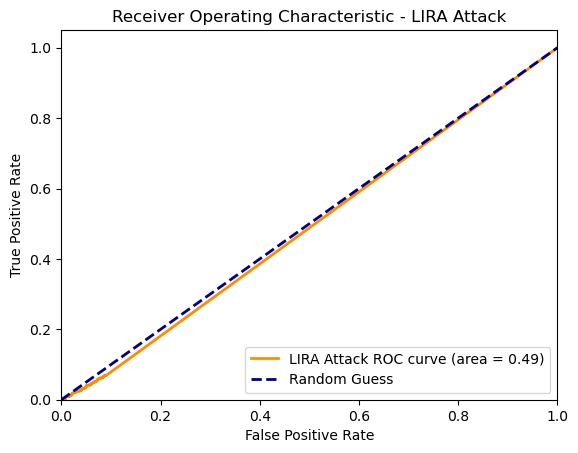

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_auc_score
labels = np.concatenate([np.ones_like(train_lrs), np.zeros_like(test_lrs)])
lrs = np.concatenate([train_lrs, test_lrs])
labels = labels[np.logical_and(lrs > -10, lrs < 10)]
lrs = lrs[np.logical_and(lrs > -10, lrs < 10)]


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, lrs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'LIRA Attack ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LIRA Attack')
plt.legend(loc="lower right")
plt.show()